# Homework 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from keras.datasets import cifar10
from keras.utils import to_categorical
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
from keras.optimizers import SGD

# Load data

In [ ]:
# Load the cifar10 dataset simply works with the function load_data().
(train_inputs, train_labels), (test_inputs, test_labels) = cifar10.load_data()

In [ ]:
print(train_inputs.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


#Print some examples from the datasets

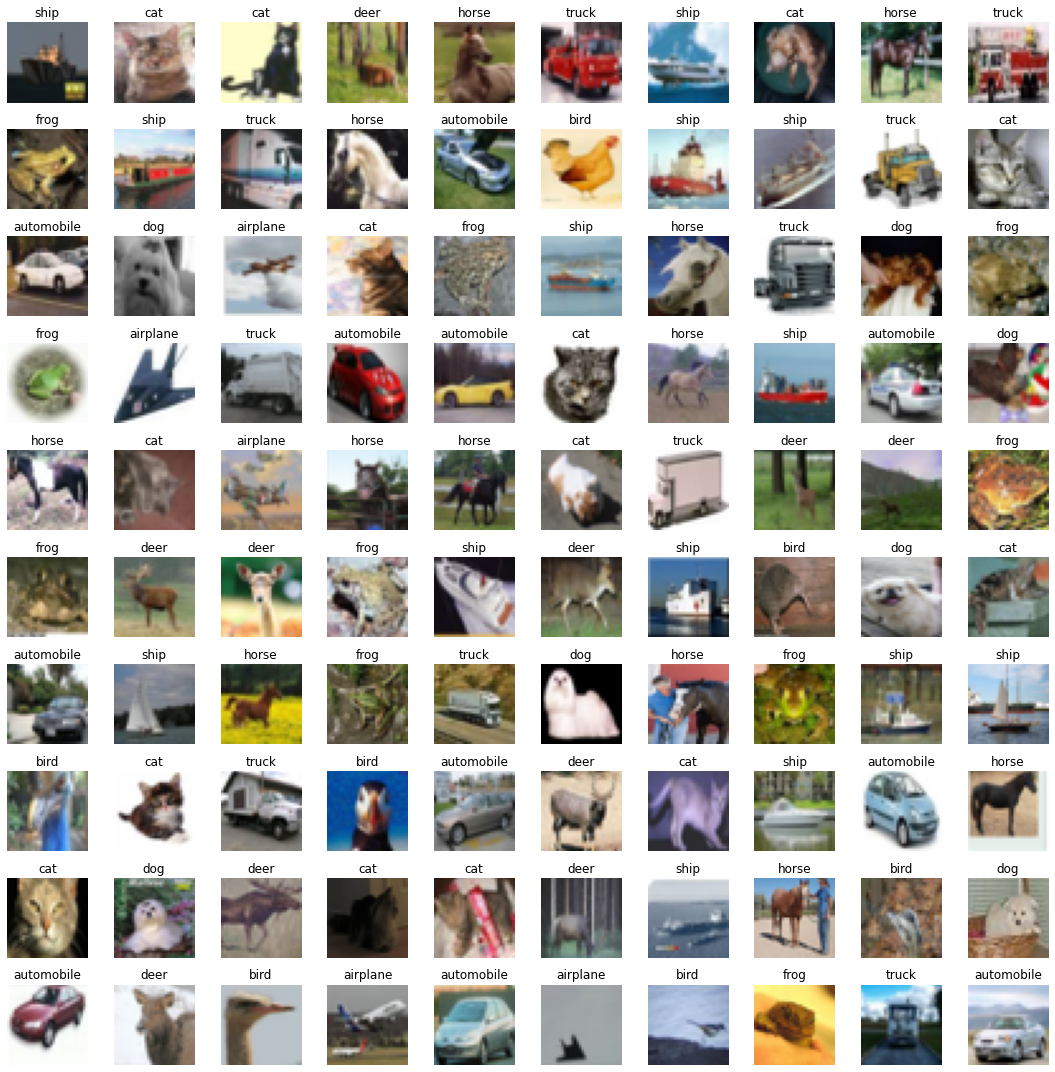

In [ ]:
# Names of labels
labels = ['airplane', 
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']


# Plot 100 examples
_, ax = plt.subplots(10, 10, figsize=(15,15))
for i, img in enumerate(train_inputs[49899:49999]):
  ax[int(i/10), i%10].imshow(img)
  ax[int(i/10), i%10].set_title(str(labels[train_labels[i+49899][0]]))
  ax[int(i/10), i%10].axis('off')

plt.tight_layout()
plt.show()

# Data Augmentation

Augmenting data like this (not generating 'on the fly') but saving them in the data arrays limits data augmentation to approximately 200.000 images as this is where for Google Colab all resources are used.

In [ ]:
# Initialize data generator:
# Changes in rotation, brightness, shifting in width and height, and flipping horizontally
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    brightness_range=(0.3,0.7),
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Create augmented data
train_generator = datagen.flow(train_inputs, train_labels, batch_size=100)

# Create new data arrays - and add augmented images
train_inputs_aug = np.zeros((90000, 32, 32, 3))
train_labels_aug = np.zeros((90000, 1))
train_inputs_aug[:50000,:,:,:] = train_inputs / 255.
train_labels_aug[:50000,:] = train_labels

# Add augmented images
pos = 50000
for i, (image, label) in enumerate(train_generator):

  # Stop after creating 40000 images
  if i >= 400:
    break
  
  train_inputs_aug[pos:pos+100,:,:,:] = image
  train_labels_aug[pos:pos+100] = label

  # Next position
  pos = pos+100


# Print some info on augmented data and show some examples

Training - image shape: (90000, 32, 32, 3), label shape: (90000, 1)
Testing - image shape: (10000, 32, 32, 3), label shape: (10000, 1)


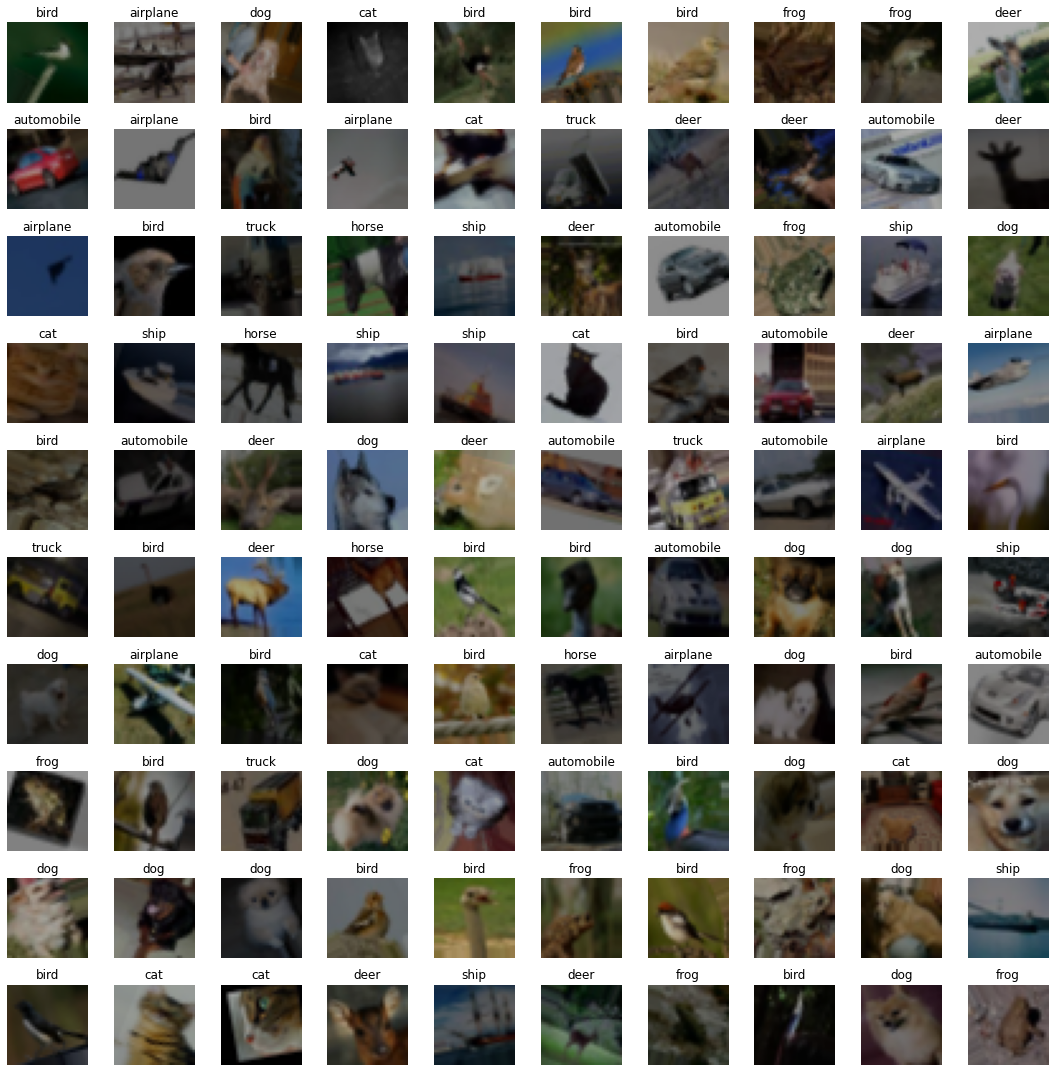

In [ ]:
# Show some info and example images
print('Training - image shape: %s, label shape: %s' % (train_inputs_aug.shape, train_labels_aug.shape))
print('Testing - image shape: %s, label shape: %s' % (test_inputs.shape, test_labels.shape))

# Some augmented training images and their labels
_, ax = plt.subplots(10, 10, figsize=(15,15))
for i, img in enumerate(train_inputs_aug[79899:79999]):
  ax[int(i/10), i%10].imshow(img)
  ax[int(i/10), i%10].set_title(str(labels[int(train_labels_aug[i+79899])]))
  ax[int(i/10), i%10].axis('off')

plt.tight_layout()
plt.show()


# Including or excluding augmented data and first data preprocessing

For the final version, we did not need the augmented data. So here, one can find the option to either use also the augmented data or not.

In [ ]:
# change dtype
include_augmented_data  = False

if include_augmented_data:
  train_inputs = train_inputs_aug.astype(np.float32)
  train_labels = train_labels_aug.astype(np.uint8)
else:
  train_inputs = train_inputs.astype(np.float32)
  train_labels = train_labels.astype(np.uint8)

test_inputs = test_inputs.astype(np.float32)
test_labels = test_labels.astype(np.uint8)

print(train_inputs.dtype)
print(train_labels.dtype)

print(test_inputs.dtype)
print(test_labels.dtype)

float32
uint8
float32
uint8


#Preprocessing Pipeline

In [ ]:
# Preprocess training data
train_inputs_prep = tf.data.Dataset.from_tensor_slices(train_inputs)
train_labels_prep = tf.data.Dataset.from_tensor_slices(train_labels)

# Normalize images and one hot encode the labels
train_inputs_prep = train_inputs_prep.map(lambda x: tf.image.per_image_standardization(x/255))
train_labels_prep = train_labels_prep.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

# Batching, shuffling and prefetching
train_data = tf.data.Dataset.zip((train_inputs_prep, train_labels_prep))
train_data = train_data.shuffle(buffer_size=10000)
train_data = train_data.batch(32, drop_remainder=True)
train_data = train_data.prefetch(buffer_size=32)

# Preprocess testing data
test_inputs_prep = tf.data.Dataset.from_tensor_slices(test_inputs)
test_labels_prep = tf.data.Dataset.from_tensor_slices(test_labels)

# Normalize images and one hot encode the labels
test_inputs_prep = test_inputs_prep.map(lambda x : tf.image.per_image_standardization(x/255))
test_labels_prep = test_labels_prep.map(lambda x: tf.reshape(tf.one_hot(x, 10), (-1,)))

# Batching, shuffling and prefetching
test_data = tf.data.Dataset.zip((test_inputs_prep, test_labels_prep))
test_data = test_data.shuffle(buffer_size=10000)
test_data = test_data.batch(32, drop_remainder=True)
test_data = test_data.prefetch(buffer_size=32)

# Define the Model

Our model consists of four big blocks that each consist of a Convolutional layer, Batch Normalization, again a Convolutional layer, Max Pooling an finally a Dropout layer. The number of filters for the Convolutional layers increase (double) for each block. After those four big blocks follows a Global Average Pooling layer and finally the output layer.

In [ ]:
from tensorflow.keras import Model
# activation functions
RELU = tf.keras.activations.relu
SOFTMAX = tf.keras.activations.softmax

class Model(Model):

  def __init__(self):
    """
    """
    super(Model, self).__init__()

    # First conv block 
    self.conv_first_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), activation=None, padding='same', input_shape=(32,32,3))
    self.batch_norm_first_1 = tf.keras.layers.BatchNormalization()
    self.conv_second_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), activation=RELU, padding='same')
    self.max_pool_1 = tf.keras.layers.MaxPool2D((2,2))
    self.dropout_1 = tf.keras.layers.Dropout(0.25)

    # Second conv block
    self.conv_first_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=None, padding='same')
    self.batch_norm_first_2 = tf.keras.layers.BatchNormalization()
    self.conv_second_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation=RELU, padding='same')
    self.max_pool_2 = tf.keras.layers.MaxPool2D((2,2))
    self.dropout_2 = tf.keras.layers.Dropout(0.25)

    # Third conv block
    self.conv_first_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=None, padding='same')
    self.batch_norm_first_3 = tf.keras.layers.BatchNormalization()
    self.conv_second_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation=RELU, padding='same')
    self.max_pool_3 = tf.keras.layers.MaxPool2D((2,2))
    self.dropout_3 = tf.keras.layers.Dropout(0.25)

    # 4.  conv block
    self.conv_first_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation=None, padding='same')
    self.batch_norm_first_4 = tf.keras.layers.BatchNormalization()
    self.conv_second_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation=RELU, padding='same')
    self.max_pool_4 = tf.keras.layers.MaxPool2D((2,2))
    self.dropout_4 = tf.keras.layers.Dropout(0.25)
    
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout_5 = tf.keras.layers.Dropout(0.3)

    # Output
    self.output_layer = tf.keras.layers.Dense(10, activation=SOFTMAX)


  @tf.function
  def call(self, x, training=True):
    """
    FORWARD STEP
    forward input x through the whole network
    """

    # First conv block 
    x = self.conv_first_1(x)
    x = self.batch_norm_first_1(x, training)
    x = self.conv_second_1(x)
    x = self.max_pool_1(x)
    if training:
      x = self.dropout_1(x)

    # Second conv block
    x = self.conv_first_2(x)
    x = self.batch_norm_first_2(x, training)
    x = self.conv_second_2(x)
    x = self.max_pool_2(x)
    if training:
      x = self.dropout_2(x)

    # Third conv block
    x = self.conv_first_3(x)
    x = self.batch_norm_first_3(x, training)
    x = self.conv_second_3(x)
    x = self.max_pool_3(x)
    if training:
      x = self.dropout_3(x)

    # 4. conv block
    x = self.conv_first_4(x)
    x = self.batch_norm_first_4(x, training)
    x = self.conv_second_4(x)
    x = self.max_pool_4(x)
    if training:
      x = self.dropout_4(x)
    
    x = self.global_pool(x)

    if training:
      x = self.dropout_5(x)

    # Output
    x = self.output_layer(x)

    return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  """
  performs one training step
  model :         our model
  input :         the input that is fed into the model
  target :        true label of input
  loss_function : our loss function
  optimizer :     our optimizer
  """
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = np.mean(np.argmax(target, axis=1) == np.argmax(prediction, axis=1))
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return np.mean(loss), accuracy 


def test(model, test_data, loss_function):
  """
  test model over complete test data set
  model :         our model
  test_data :     our test data
  loss_function : our loss function
  """

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  # iterate over the test data set and predict each label
  # also calculate loss and accuracy 
  for (input, target) in test_data:

    # For testing, leave out the dropout and Batch Normalization layers by setting training=False
    prediction = model(input, training=False)
    loss = cross_entropy_loss(target, prediction)
    accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1)) / target.shape[0]
    test_accuracy_aggregator.append(accuracy)
    test_loss_aggregator.append(loss)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

# Set hyperparameters and initialize the model

In [ ]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 100
learning_rate = 0.0001
running_average_factor = 0.95

model = Model()

cross_entropy_loss = tf.keras.losses.categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing once before we begin
#test_loss, test_accuracy = test(model, test_data, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
#train_loss, train_accuracy = test(model, train_data, cross_entropy_loss)
#train_losses.append(train_loss)
#train_accuracies.append(train_accuracy)

# Training the model

In [ ]:
# We train for num_epochs epochs.
for epoch in range(num_epochs):
  
  # Track epoch and time while code runs
  start = time.time()
  print('Epoch: __ ' + str(epoch+1))
  """  
  if epoch < 25: 
    learning_rate = 1.05 * learning_rate
    optimizer = tf.keras.optimizers.Adam(learning_rate)
  else:
    learning_rate = 0.999 * learning_rate 
    optimizer = tf.keras.optimizers.Adam(learning_rate)
  """

  train_data = train_data.shuffle(buffer_size=256)
  test_data = test_data.shuffle(buffer_size=256)

  #training (and checking in with training)
  running_average_loss = 0
  running_average_accuracy = 0

  for (input, target) in train_data:
      train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
      running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
      running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #testing
  test_loss, test_accuracy = test(model, test_data, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  duration = time.time() - start

  # Measure time required for each epoch + show loss and accuracy progress
  print('... finished after %s seconds --- Train loss: %s - Train accuracy: %s --- Test loss: %s - Test accuracy: %s ' % (round(duration, 2), round(running_average_loss, 4), round(running_average_accuracy, 4), round(test_loss, 4), round(test_accuracy, 4)))

Epoch: __ 1
... finished after 48.39 seconds --- Train loss: 1.3589 - Train accuracy: 0.5243 --- Test loss: 1.5801 - Test accuracy: 0.4682 
Epoch: __ 2
... finished after 46.91 seconds --- Train loss: 1.1373 - Train accuracy: 0.5785 --- Test loss: 1.1294 - Test accuracy: 0.6028 
Epoch: __ 3
... finished after 47.17 seconds --- Train loss: 0.9551 - Train accuracy: 0.6506 --- Test loss: 0.9966 - Test accuracy: 0.6502 
Epoch: __ 4
... finished after 48.13 seconds --- Train loss: 0.8917 - Train accuracy: 0.6817 --- Test loss: 0.874 - Test accuracy: 0.6984 
Epoch: __ 5
... finished after 48.11 seconds --- Train loss: 0.822 - Train accuracy: 0.7097 --- Test loss: 0.7831 - Test accuracy: 0.7278 
Epoch: __ 6
... finished after 48.16 seconds --- Train loss: 0.8223 - Train accuracy: 0.7191 --- Test loss: 0.7443 - Test accuracy: 0.74 
Epoch: __ 7
... finished after 48.39 seconds --- Train loss: 0.7507 - Train accuracy: 0.7473 --- Test loss: 0.7171 - Test accuracy: 0.7501 
Epoch: __ 8
... finished

# Plot results

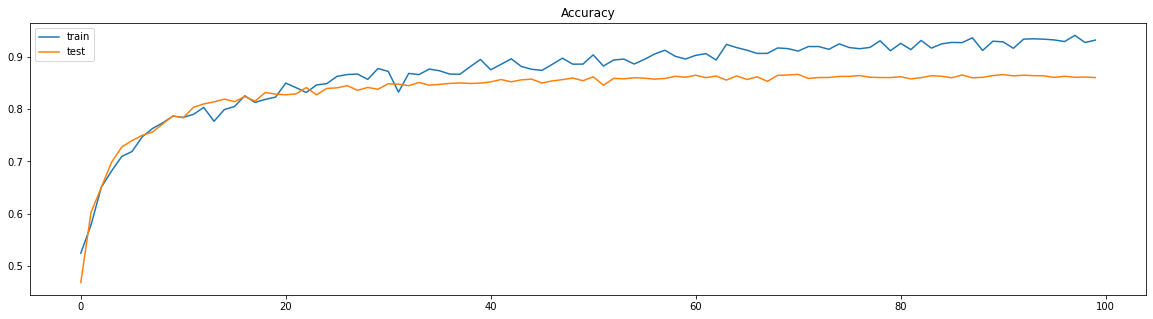

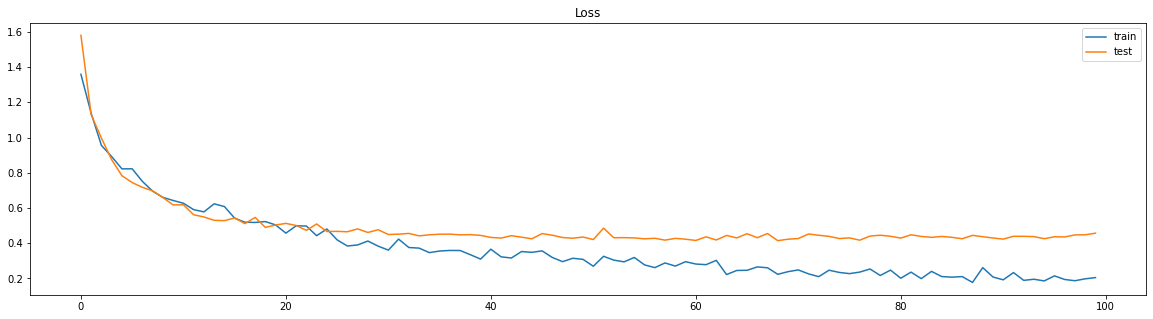

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.figure(figsize=(20,5))
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.title("Loss")
plt.show()

# Check final accuracies

If we take a look at the last 15 epochs we can see that minimum and maximum test accuracy are very similar. Also in the plot we can see that starting around epochs 60-70 the model starts overfitting slightly: The test accuracy remains at values around 86% while the training accuracy further increased. So, training for fewer epochs would have sufficed for our case.



In [ ]:
print("mean:", np.mean(test_accuracies[-15:-1]))
print("min:", np.min(test_accuracies[-15:-1]))
print("max:", np.max(test_accuracies[-15:-1]))

mean: 0.8630880837912088
min: 0.8602764423076923
max: 0.866386217948718
